In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import torch
import torchvision

The aim of this notebook is to recreate the pytorch_mnist notebook using only numpy

### Load data

I'll use torchvision to load the data just for convenience, all training will be done using only numpy

In [51]:
train_batch_size = 64
test_batch_size = 1000

In [52]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./datasets', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(0, 1)
                              ])),
    batch_size=train_batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./datasets', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize(0, 1)
                              ])),
    batch_size=test_batch_size, shuffle=True
)

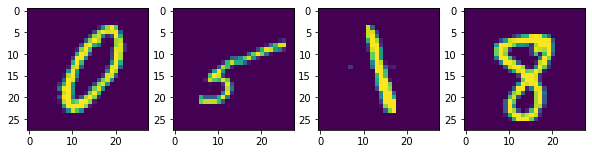

In [53]:
# visualize some images
train_iter = iter(train_loader)
images, labels = train_iter.next()
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(1, 4, i+1)
    ax.imshow(images[i].reshape(28, 28))

### Build simple neural network using numpy

In [54]:
def initialize_weights():
    # weights and bias for each layer
    return [np.random.randn(784, 200), np.random.randn(200,), 
            np.random.randn(200, 10), np.random.randn(10,)]

In [55]:
def relu(x):
    x[x <= 0] = 0
    return x

In [56]:
def dx_relu(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

In [57]:
def softmax(outputs, labels):
    return np.exp(outputs) / np.sum(np.exp(outputs), axis=1).reshape(-1, 1)

In [58]:
def dx_cross_entropy_loss(outputs, labels):
    sm = softmax(outputs, labels)
    sm[range(len(labels)), labels] -= 1
    return (1/outputs.shape[0]) * sm

In [59]:
def cross_entropy_loss(outputs, labels):
    return np.mean(-np.log((np.exp(outputs[range(outputs.shape[0]), labels])) / np.sum(np.exp(outputs), axis=1)))

In [67]:
W1, b1, W2, b2 = initialize_weights()
lr = 0.01
losses = []
accuracies = []
for epoch in range(10):
    total_loss = 0
    total_accuracy = 0
    for i, data in tqdm(enumerate(train_loader)):
        images, labels = data
        images = images.numpy() #(64, 1, 28, 28)
        labels = labels.numpy() #(64,)
        batch_size = images.shape[0]
        
        # forward pass
        images = images.reshape(batch_size, -1)
        H1 = images.dot(W1) + b1 # (64, 200)
        A1 = relu(H1) # (64, 200)
        H2 = A1.dot(W2) + b2 # (64, 10)
        
        # calculate loss
        loss = cross_entropy_loss(H2, labels)
        losses.append(loss)
        total_loss += loss
        
        # calculate accuracy
        accuracy = (np.argmax(H2, axis=1) == labels).sum() / labels.shape[0]
        accuracies.append(accuracy)
        total_accuracy += accuracy
        
        # backward pass, compute gradients
        dx_h2 = dx_cross_entropy_loss(H2, labels) # (64, 10)
        dx_w2 = A1.T.dot(dx_h2) # (200, 10)
        dx_b2 = np.ones((1, batch_size)).dot(dx_h2).flatten() # (10,)
        dx_a1 = dx_h2.dot(W2.T) # (64, 200)
        dx_h1 = np.multiply(dx_relu(H1), dx_a1) # (64, 200)
        dx_w1 = images.T.dot(dx_h1) # (784, 200)
        dx_b1 = np.ones((1, batch_size)).dot(dx_h1).flatten() # (200,)
        
        # SGD update weights
        W1 = W1 - (lr * dx_w1)
        W2 = W2 - (lr * dx_w2)
        b1 = b1 - (lr * dx_b1)
        b2 = b2 - (lr * dx_b2)
#         print(W1.shape, W2.shape, b1.shape, b2.shape)
    print(f'Epoch {epoch+1}, Loss: {total_loss/(i+1)}, Accuracy: {total_accuracy/(i+1)}')

938it [00:12, 74.53it/s]
7it [00:00, 67.61it/s]

Epoch 1, Loss: 13.194297445099831, Accuracy: 0.7275453091684435


938it [00:12, 75.28it/s]
7it [00:00, 67.11it/s]

Epoch 2, Loss: 5.317165231843682, Accuracy: 0.845599013859275


938it [00:14, 66.89it/s]
7it [00:00, 68.08it/s]

Epoch 3, Loss: 3.9857612361527774, Accuracy: 0.8687200159914712


938it [00:13, 71.86it/s]
3it [00:00, 22.61it/s]

Epoch 4, Loss: 3.260568229300271, Accuracy: 0.8810967484008528


938it [00:15, 60.35it/s]
7it [00:00, 68.20it/s]

Epoch 5, Loss: 2.774062645781404, Accuracy: 0.8900086620469083


938it [00:17, 54.26it/s]
7it [00:00, 68.89it/s]

Epoch 6, Loss: 2.4217089825848648, Accuracy: 0.8962553304904051


938it [00:14, 63.19it/s]
8it [00:00, 71.42it/s]

Epoch 7, Loss: 2.142545168562154, Accuracy: 0.9020855543710021


938it [00:13, 69.13it/s]
5it [00:00, 34.52it/s]

Epoch 8, Loss: 1.9255160807518787, Accuracy: 0.9057002931769723


938it [00:14, 62.74it/s]
7it [00:00, 70.00it/s]

Epoch 9, Loss: 1.7521180071376068, Accuracy: 0.9103644722814499


938it [00:14, 67.00it/s]

Epoch 10, Loss: 1.5993406731804305, Accuracy: 0.9133795309168443


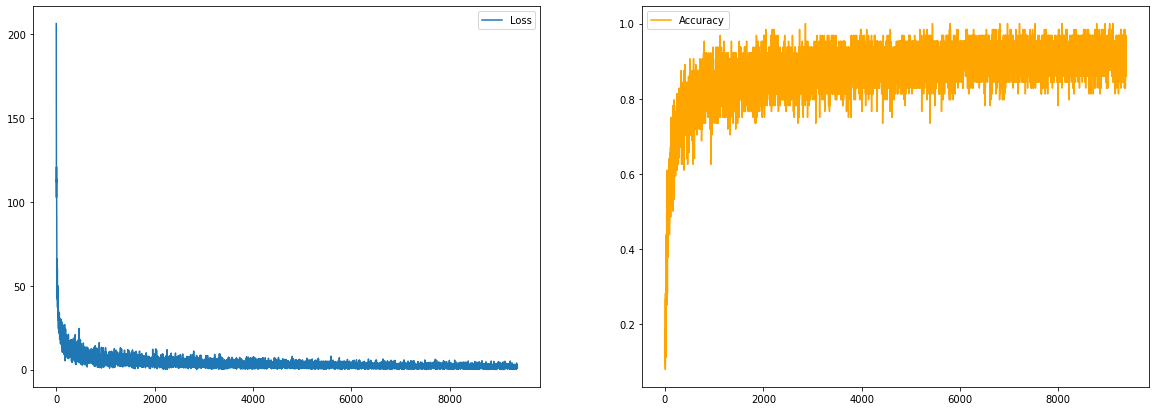

In [79]:
plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(losses)
ax1.legend(['Loss'])
ax2 = plt.subplot(1, 2, 2)
ax2.plot(accuracies, color='orange')
ax2.legend(['Accuracy'])
plt.show()

In [88]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    images = images.numpy().reshape(images.shape[0], -1)
    labels = labels.numpy()
    
    # forward pass
    H1 = images.dot(W1) + b1 # (64, 200)
    A1 = relu(H1) # (64, 200)
    H2 = A1.dot(W2) + b2 # (64, 10)
    
    correct += (np.argmax(H2, axis=1) == labels).sum()
    total += labels.shape[0]
print(f'Accuracy on test set: {correct / total}')

Accuracy on test set: 0.9087
